<a href="https://colab.research.google.com/github/stiwari-ds/data-science-competitions/blob/main/dphi/predicting_career_longevity_NBA/notebooks/01_eda_and_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [20]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('precision', 4)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

SEED = 23
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [2]:
train_url = 'https://raw.githubusercontent.com/stiwari-ds/data-science-competitions/main/dphi/predicting_career_longevity_NBA/data/Train_data.csv'
test_url = 'https://raw.githubusercontent.com/stiwari-ds/data-science-competitions/main/dphi/predicting_career_longevity_NBA/data/Test_data.csv'

In [3]:
train = pd.read_csv(train_url)
test = pd.read_csv(test_url)

In [4]:
train.head()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,Target
0,59.0,12.8,3.4,1.3,2.6,51.0,0.2,0.3,50.0,0.7,0.8,78.0,1.1,2.3,3.3,0.5,0.3,0.4,0.5,1
1,31.0,10.7,3.4,1.2,3.3,35.3,0.5,2.1,25.8,0.5,0.9,55.2,0.3,1.1,1.4,0.4,0.3,0.1,0.2,0
2,48.0,9.3,4.5,1.7,3.4,49.7,0.0,0.1,0.0,1.2,1.9,61.5,0.4,0.8,1.2,0.8,0.5,0.4,1.0,0
3,80.0,27.7,11.2,3.5,9.4,37.4,1.3,4.1,32.9,2.8,3.3,85.0,0.8,1.6,2.4,3.9,1.3,0.1,2.2,1
4,58.0,18.4,5.8,1.9,5.3,36.7,0.0,0.1,25.0,1.9,3.1,61.7,0.5,0.7,1.2,1.9,1.1,0.2,1.7,0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1101 entries, 0 to 1100
Data columns (total 20 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   GP       1101 non-null   float64
 1   MIN      1101 non-null   float64
 2   PTS      1101 non-null   float64
 3   FGM      1101 non-null   float64
 4   FGA      1101 non-null   float64
 5   FG%      1101 non-null   float64
 6   3P Made  1101 non-null   float64
 7   3PA      1101 non-null   float64
 8   3P%      1101 non-null   float64
 9   FTM      1101 non-null   float64
 10  FTA      1101 non-null   float64
 11  FT%      1101 non-null   float64
 12  OREB     1101 non-null   float64
 13  DREB     1101 non-null   float64
 14  REB      1101 non-null   float64
 15  AST      1101 non-null   float64
 16  STL      1101 non-null   float64
 17  BLK      1101 non-null   float64
 18  TOV      1101 non-null   float64
 19  Target   1101 non-null   int64  
dtypes: float64(19), int64(1)
memory usage: 172.2 KB


# Feature selection

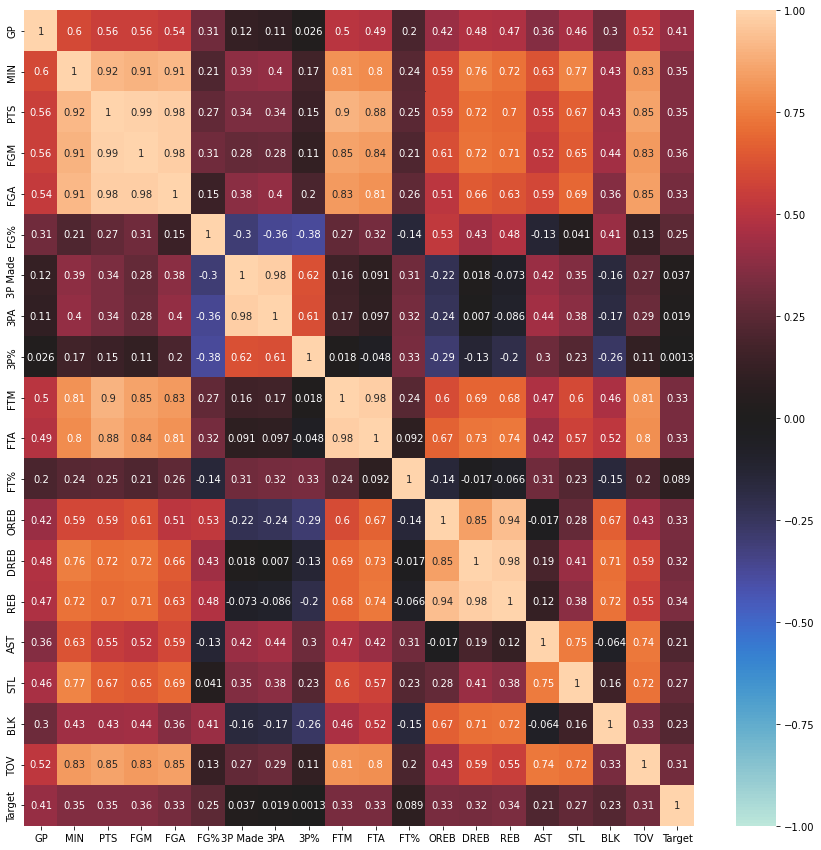

In [6]:
plt.figure(figsize=(15, 15))
sns.heatmap(train.corr(), vmin=-1, vmax=1, center=0, annot=True)
plt.show()

In [7]:
features = list(test.columns)
TARGET = 'Target'

In [8]:
anova_test = f_classif(train[features], train[TARGET])

pd.DataFrame(
    data={'f-statistic': anova_test[0], 
          'p-value': anova_test[1]}, 
    index=features
)

,f-statistic,p-value
GP,222.4612,5.9585e-46
MIN,157.6087,7.0347e-34
PTS,157.6492,6.9105e-34
FGM,159.6192,2.9065e-34
FGA,132.4775,5.0251e-29
FG%,74.6725,1.9324e-17
3P Made,1.5196,2.1794e-01
3PA,0.3869,5.3408e-01
3P%,0.0018,9.6604e-01
FTM,137.1569,6.1582e-30


In [9]:
mi_scores = mutual_info_classif(train[features], train[TARGET], random_state=SEED)

mi_score_percent = mi_scores / sum(mi_scores) * 100

pd.DataFrame(
    data={'mi_score': mi_scores,
          'mi_score_percent': mi_score_percent}, 
    index=features
)

,mi_score,mi_score_percent
GP,0.1701,8.2783
MIN,0.0700,3.4091
PTS,0.0988,4.8099
FGM,0.1708,8.3126
FGA,0.1151,5.6021
FG%,0.0521,2.5350
3P Made,0.0692,3.3688
3PA,0.0539,2.6217
3P%,0.0000,0.0000
FTM,0.1542,7.5060


In [10]:
redundant_features = ['FGM', 'FGA', 'OREB','DREB', 'FTM', #high corr with other features 
                      '3P Made', '3PA', '3P%', 'FT%'] #low corr with target
selected_features = [f for f in features if f not in redundant_features]

# Baseline

In [11]:
target = train[TARGET]
train = train[features]
test = test[features]

In [12]:
xtrain, xval, ytrain, yval = train_test_split(
    train, target, 
    test_size=0.2, 
    stratify=target, 
    shuffle=True, 
    random_state=SEED)

In [21]:
def create_model():
    """Create preprocessing and modeling pipeline, return a Pipeline instance."""
    
    # categorical_pipeline = Pipeline([
    #     ('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore'))
    # ])

    numerical_pipeline = Pipeline([
        ('standardize', RobustScaler()),
        ('normalize', MinMaxScaler())
    ])
    
    preprocessor = ColumnTransformer([
        # ('cat_preprocessor', categorical_pipeline, make_column_selector(dtype_include='category')),
        ('num_preprocessor', numerical_pipeline, make_column_selector(dtype_include='number'))
    ])

    model = Pipeline([
        ('preprocessing', preprocessor),
        ('modeling', LogisticRegression(random_state=SEED, solver='liblinear'))
    ])
    
    return model

In [22]:
model1 = create_model()
model1.fit(xtrain, ytrain)

val_probs1 = model1.predict_proba(xval)[:, 1] #probability of class = 1
val_preds1 = model1.predict(xval)

print(f'AUC = {roc_auc_score(yval, val_probs1):.4f}')
print('Classification report:')
print(classification_report(yval, val_preds1, target_names=['class 0', 'class 1']))

AUC = 0.7840
Classification report:
              precision    recall  f1-score   support

     class 0       0.72      0.66      0.69       111
     class 1       0.68      0.75      0.71       110

    accuracy                           0.70       221
   macro avg       0.70      0.70      0.70       221
weighted avg       0.70      0.70      0.70       221



In [23]:
model2 = create_model()
model2.fit(xtrain[selected_features], ytrain)

val_probs2 = model2.predict_proba(xval[selected_features])[:, 1]
val_preds2 = model2.predict(xval[selected_features])

print(f'AUC = {roc_auc_score(yval, val_probs2):.4f}')
print('Classification report:')
print(classification_report(yval, val_preds2, target_names=['class 0', 'class 1']))

AUC = 0.7835
Classification report:
              precision    recall  f1-score   support

     class 0       0.72      0.66      0.69       111
     class 1       0.68      0.75      0.71       110

    accuracy                           0.70       221
   macro avg       0.70      0.70      0.70       221
weighted avg       0.70      0.70      0.70       221

